<a href="https://colab.research.google.com/github/ubsuny/LLPS-ProteinRNA_Condensates-CP2P2024/blob/main/Video_Particle_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install multipletau

In [ ]:
!pip install lmfit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 9.9 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import math
# Import the autocorrelate function from the multipletau package.
# Multipletau is a library for performing autocorrelation analysis,
# a statistical method to find repeating patterns, such as the presence
# of a periodic signal obscured by noise, or identifying the missing
# fundamental frequency in a signal using a fast algorithm designed for
# non-uniformly sampled correlation functions.
from multipletau import autocorrelate
# Import the array module to create and manipulate compact arrays of
# basic data types.
import array

# Import the lmfit library, which provides a high-level interface to
# non-linear optimization and curve fitting problems for Python.
import lmfit
import scipy as sp
import numpy as np

# Import the listdir function from the os module to list the names of the
# entries in the directory given by path.
from os import listdir
# Import sys and os.path modules for interacting with the Python interpreter
# and operating system's filesystem, respectively.
# These are typically used for manipulating Python's runtime environment and handling file paths.
import sys, os.path

In [ ]:
def ReadTable(filename, beadindx=-1, X=0, Y=1, indx=2, skip=1):
    """
    Reads a table from a whitespace-separated text file. The table is expected to have a rectangular shape
    with no missing data points. Each row represents a data point, and each column a variable.

    Parameters:
    - filename: Path to the text file to be read.
    - beadindx: Column index to use for factorization, defaults to the last column.
    - X: Column index for the x coordinate.
    - Y: Column index for the y coordinate.
    - indx: Column index for the image index, which is proportional to time.
    - skip: Number of lines to skip at the beginning of the file, defaults to 1.

    Returns:
    - A list of dictionaries, each representing a trajectory (bead) with keys 'X', 'Y', and 'indx'.
      'X' and 'Y' are arrays of coordinates, and 'indx' is the image index (time).
    """

    # Check if the specified file exists on the file system
    if os.path.isfile(filename):
        # If the file exists, open it for reading as text ('rt')
        fp = open(filename, 'rt')
    else:
        # If the file does not exist, print an error message and return None
        print("file not found: %s" % filename)
        return None

    # Read all lines from the file into a list where each item represents a line
    a = fp.readlines()
    # Close the file to free up system resources
    fp.close()

    # Ignore the first 'skip' number of lines as specified by the function's argument
    a = a[skip:]
    # Determine the number of remaining lines after skipping
    Ni = len(a)
    # Estimate the number of columns in the data by splitting the first row on commas and subtracting 1
    # (assuming the first column is not part of the data to be processed)
    t = (a[0].strip()).split(',')
    Nj = len(t) - 1

    # Initialize an empty list to store the processed data rows
    res = []
    # Iterate over each line (after skipping the initial lines) in the data
    for i in range(Ni):
        # Strip leading and trailing whitespace and split the line on commas
        t = a[i].strip().split(',')

        # Initialize an empty list to store the processed elements of the current line
        l = []
        # Iterate over each column in the line, starting from the second column (index 1)
        for j in range(Nj):
            # If the current column is empty, skip it
            if t[j + 1] == '':
                continue
            # Convert the column value to a float and add it to the list for the current line
            l.append(float(t[j + 1]))

        # Add the processed line to the overall results list
        res.append(l)
    # The 'for i' loop ends here
    # Print the number of lines found and processed
    print("Found: %d lines" % len(res))

    # Convert the list of lists (res) to a numpy array for easier numerical manipulation
    res = nu.asarray(res)
    # Identify unique bead indices by examining the specified 'beadindx' column and counting unique values
    Nb = nu.unique(res[:, beadindx - 1])
    # Print the number of unique beads found
    print("Max: %d beads" % len(Nb))

    # Initialize an empty list to store data for each unique bead
    poslist = []
    # Iterate over each unique bead index
    for i in Nb:
        # Find the rows corresponding to the current bead index
        bindx = (res[:, beadindx - 1] == i)
        # For each bead, create a dictionary with 'X', 'Y', and 'indx' keys containing the respective data
        # The data for each key is extracted from the 'res' array using boolean indexing
        poslist.append({"X": res[bindx, X - 1], "Y": res[bindx, Y - 1],
                        "indx": res[bindx, indx - 1]})
    # Print the total number of beads for which data has been organized
    print("Found: %d beads" % len(poslist))

    # Return the list of dictionaries, each representing a unique bead and its corresponding data
    return poslist


In [ ]:
import numpy as np
import xml.etree.ElementTree as et

# Define the function loadxmlTrajs with a single parameter 'xmlfile' which is the path to the XML file.
def loadxmlTrajs(xmlfile):
    """
    Load xml files into a python dictionary with the following structure:
        tracks = {'0': {'nSpots': 20, 'trackData': numpy.array(t, x, y, z) }}
    Tracks should be xml file from 'Export tracks to XML file',
    that contains only track info but not the features.
    Similar to what 'importTrackMateTracks.m' needs.
    """
    # Attempt to parse the XML file into an ElementTree object.
    try:
        tree = et.parse(xmlfile);
    except OSError:
        # If an error occurs (e.g., file not found), print an error message.
        # Note: There's a typo in 'xlmfile'. It should be 'xmlfile'.
        print('Failed to read XML file {}.'.format(xmlfile))
    # Get the root element of the XML tree.
    root = tree.getroot()
    # Optionally print or extract metadata from the root element's attributes.
    # Get the total number of tracks from the root attribute 'nTracks' and convert it to an integer.
    nTracks = int(root.attrib['nTracks'])
    # Initialize an empty dictionary to hold the track data.
    tracks = {}
    # Loop through each track in the XML file.
    for i in range(nTracks):
        # Convert the track index to a string to use as a dictionary key.
        trackIdx = str(i)
        # Initialize a sub-dictionary for this track, starting with an empty dictionary.
        tracks[trackIdx] = {}
        # Get the number of spots (points) in this track and convert it to an integer.
        nSpots = int(root[i].attrib['nSpots'])
        # Store the number of spots in the sub-dictionary under 'nSpots'.
        tracks[trackIdx]['nSpots'] = nSpots
        # Initialize an empty numpy array to hold the track data. It's initially shaped (0, 4) for [t, x, y, z].
        trackData = np.array([]).reshape(0, 4)
        # Loop through each spot in the current track.
        for j in range(nSpots):
            # Extract the time (t) and spatial coordinates (x, y, z) from the spot's attributes and convert them to floats.
            t = float(root[i][j].attrib['t'])
            x = float(root[i][j].attrib['x'])
            y = float(root[i][j].attrib['y'])
            z = float(root[i][j].attrib['z'])
            # Create a numpy array for this spot's data.
            spotData = np.array([t, x, y, z])
            # Add the spot's data to the trackData array.
            trackData = np.vstack((trackData, spotData))
        # Store the accumulated trackData in the sub-dictionary under 'trackData'.
        tracks[trackIdx]['trackData'] = trackData
    # Return the dictionary containing all tracks and their data.
    return tracks

# Define the function get_outlier_bounds with two parameters: first_values and last_values.
# These are arrays or sequences of numerical values.
def get_outlier_bounds(first_values, last_values):

    # First, sort the log-transformed values of the first dataset.
    # Log transformation is applied to normalize data and reduce the impact of very high or low values.
    sorted_f = np.sort(np.log(first_values))

    # Calculate the first (Q1) and third (Q3) quartiles of the sorted, log-transformed first dataset.
    # These quartiles split the data into four equal parts.
    q1, q3 = np.percentile(sorted_f, [25, 75])

    # Calculate the interquartile range (IQR) by subtracting Q1 from Q3.
    # The IQR measures the middle spread of the data.
    iqr = q3 - q1

    # Calculate the lower bound for outliers in the first dataset.
    # Outliers are defined as values below (Q1 - 1.5 * IQR).
    lower_bound = q1 - (1.5 * iqr)

    # Calculate the upper bound for outliers in the first dataset.
    # Outliers are defined as values above (Q3 + 1.5 * IQR).
    upper_bound = q3 + (1.5 * iqr)

    # Repeat the process for the second dataset: sort the log-transformed values.
    sorted_l = np.sort(np.log(last_values))

    # Calculate the first (Q1) and third (Q3) quartiles for the sorted, log-transformed second dataset.
    q1, q3 = np.percentile(sorted_l, [25, 75])

    # Calculate the interquartile range (IQR) for the second dataset.
    iqr = q3 - q1

    # Calculate the lower bound for outliers in the second dataset.
    # The factor here is 1 instead of 1.5 used for the first dataset, which could be a specific choice or an inconsistency.
    lower_bound_l = q1 - (1 * iqr)

    # Calculate the upper bound for outliers in the second dataset using the same method as for the first dataset.
    upper_bound_l = q3 + (1.5 * iqr)

    # Return the calculated lower and upper bounds for both datasets.
    # This allows for separate outlier detection in each dataset based on their respective bounds.
    return lower_bound, upper_bound, lower_bound_l, upper_bound_l


In [ ]:
import os
format_file = '.xml'  # Specify the file format you're interested in
directory_path = "/content"  # Specify the directory path where your files are located

# List all files in the directory
files = os.listdir(directory_path)

scans = []
# fraps=[]
for file in files:
    if format_file in file:
        scans.append(file)

index = np.arange(len(scans))
# 'list(index)' converts the array 'index' to a list, and 'scans' is already a list of file names.
insca = zip(list(index), scans)

# Convert the zip object to a list to view it
insca_list = list(insca)
print(insca_list)


[(0, 'video4_1_MMStack_Pos0_Tracks.xml')]


In [ ]:
# Set the index of the file to analyze. This selects the first file in the 'scans' list (0-based indexing).
index_to_analyze = 0

# Retrieve the filename from the 'scans' list at the position specified by 'index_to_analyze'.
fname = scans[index_to_analyze]

# Remove the last 4 characters from the filename. This is typically done to strip the file extension.
# For example, if the file name was 'data.xml', this operation changes it to 'data'.
fname = fname[0:len(fname)-4]

# Load the file's content using the 'loadxmlTrajs' function. The '.xml' extension is appended back to 'fname'.
# This function is expected to parse the XML file and return its contents in a structured format.
pos = loadxmlTrajs(fname+'.xml')


In [ ]:
# Total duration of the video in seconds
total_duration = 100  # [s]

# Total number of frames in the video
total_frames = 1000  # [frames]

# Calculate the frame time (time interval between frames)
frametime = total_duration / total_frames # = 0.1 second

# This frame time is used for all subsequent calculations involving time,
# such as computing the mean squared displacement (MSD).

pixel_conversion = 1  # Conversion factor from pixels to microns, which is
                      # equivalent to 0.172 microns as per the ImageJ scale setting
R = 0.5  # Radius of the bead in microns
T = 20  # Temperature in Celsius during the experiment


In [ ]:
# Initialize a numpy array 'sizes' with zeros, with its length equal to the
# number of items in 'pos'. This array is intended to store the number of
# spots ('nSpots') for each track in 'pos'.
sizes = np.zeros((len(pos),))

# Iterate over the range of indices from 0 to the length of 'pos' - 1.
for i in range(len(pos)):
    # Access each track by its string representation of the index ('str(i)')
    # in 'pos'.
    # Retrieve the number of spots ('nSpots') for that track and store it in
    # the corresponding index of 'sizes'.
    sizes[i] = pos[str(i)]['nSpots']

lastframe = int(max(sizes)) # represents the highest number of spots in any track.
minframe = int(min(sizes))  # represents the lowest number of spots in any track.


In [ ]:
lastframe, len(pos)

(1000, 24)

In [ ]:
# Initialize arrays filled with zeros to store cumulative displacements
# in the x and y directions for each time frame.
dx_all = np.zeros(int(lastframe - 1),)
dy_all = np.zeros(int(lastframe - 1),)
# Initialize an array to count the number of displacements added per time frame.
count_all = np.zeros(int(lastframe - 1),)
# Initialize an empty list to potentially store counts, although it is not
# used in this snippet.
counts = []

# Loop over each track (or object) identified in the 'pos' data structure.
for j in range(int(len(pos))):
    # Initialize variables for average velocity and position, which are not
    # used in the further calculation within this snippet.
    Vavg = 0
    Xavg = 0
    # Initialize a counter for the number of displacements, not utilized in the
    # subsequent logic.
    count = 0
    # Calculate the difference in x positions (dx) between consecutive time
    # points for the jth track.
    dx = np.diff(pos[str(j)]['trackData'][:, 1])
    # Calculate the difference in y positions (dy) between consecutive time
    # points for the jth track.
    dy = np.diff(pos[str(j)]['trackData'][:, 2])
    # Extract the time points for the jth track.
    time = pos[str(j)]['trackData'][:, 0]
    # Determine the start index for displacement based on the first time point.
    start = int(time[0])
    # Determine the end index for the displacement calculation.
    end = start + len(dx)
    # Accumulate the dx values to the cumulative displacement array dx_all for
    # the respective time frames.
    dx_all[start:end] = dx_all[start:end] + dx
    # Accumulate the dy values to the cumulative displacement array dy_all for
    # the respective time frames.
    dy_all[start:end] = dy_all[start:end] + dy
    # Increment the count for each time frame that has received a new displacement.
    count_all[start:end] = count_all[start:end] + 1
    # Calculate the average displacement in x direction by dividing cumulative
    #  displacements by their respective counts.
    dx_avg = dx_all / count_all
    # Calculate the average displacement in y direction by dividing cumulative
    # displacements by their respective counts.
    dy_avg = dy_all / count_all

# Calculate the initial center of mass position based on the first positions of
# all tracks.
Xcom0 = 0
Ycom0 = 0
# Loop over each key in 'pos' to sum up initial x and y positions of all tracks.
for key in pos:
    Xcom0 += pos[key]['trackData'][0, 1]
    Ycom0 += pos[key]['trackData'][0, 2]
# Calculate the average initial x position (X0) by dividing the total initial
#  x positions by the number of tracks.
X0 = Xcom0 / len(pos)
# Calculate the average initial y position (Y0) by dividing the total initial
# y positions by the number of tracks.
Y0 = Ycom0 / len(pos)

# Calculate the cumulative x and y positions (Xcom and Ycom) of the center
# of mass for each time frame.
Xcom = [X0 + sum(dx_avg[:i]) for i in range(int(lastframe))]
Ycom = [Y0 + sum(dy_avg[:i]) for i in range(int(lastframe))]


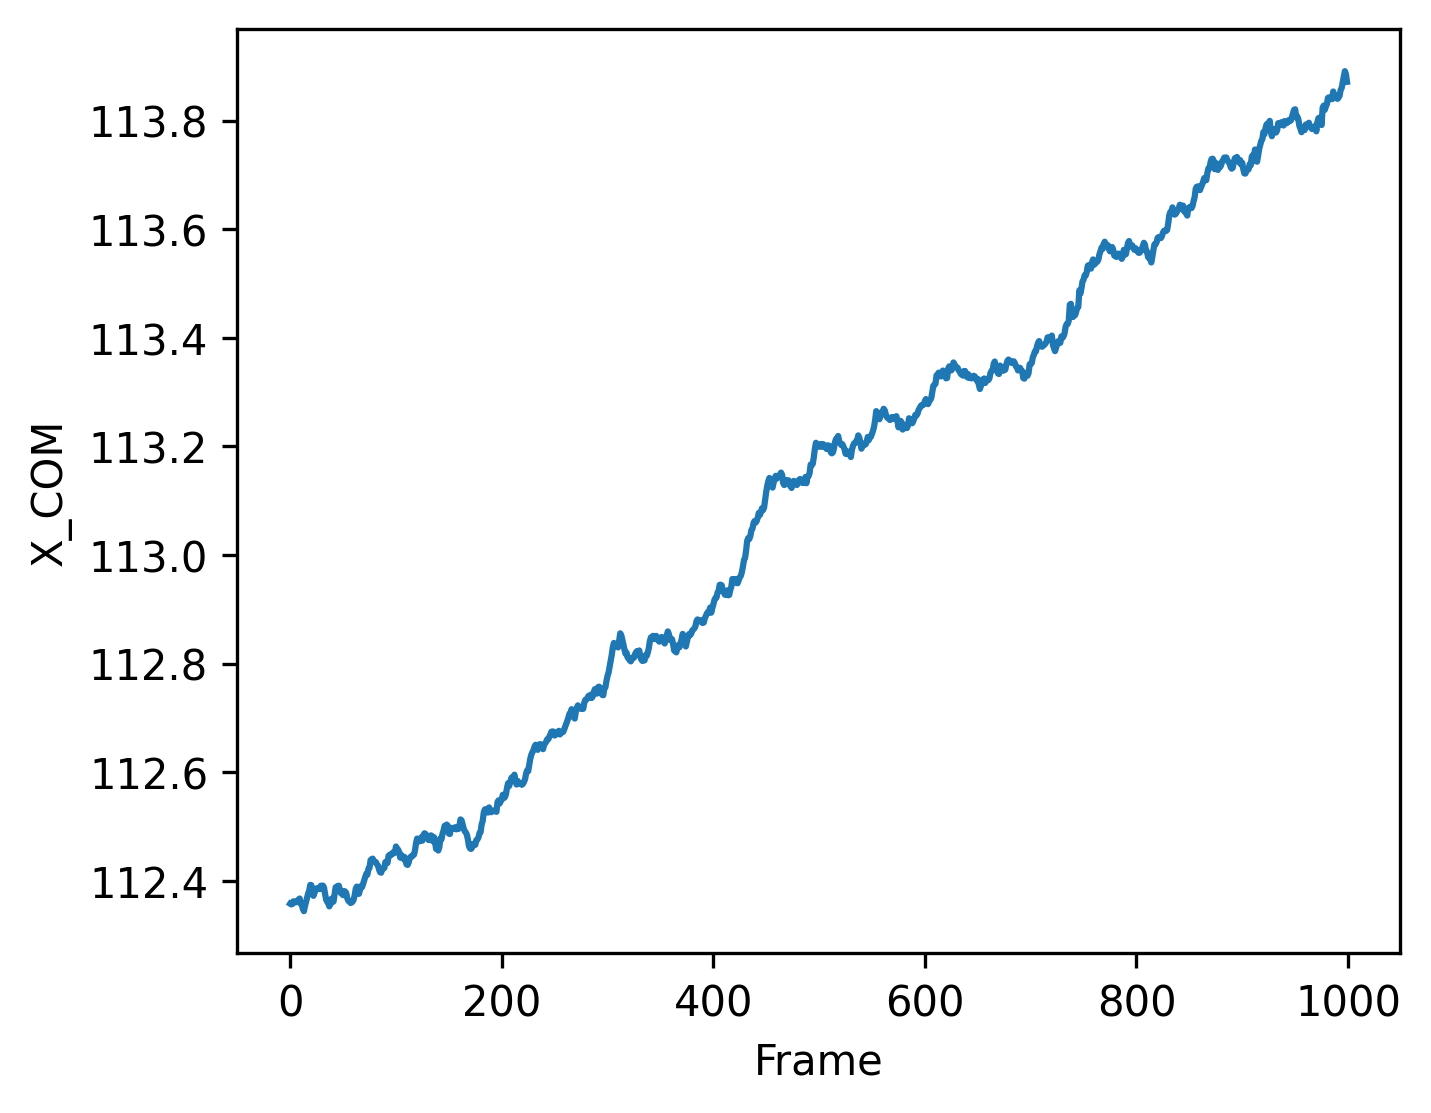

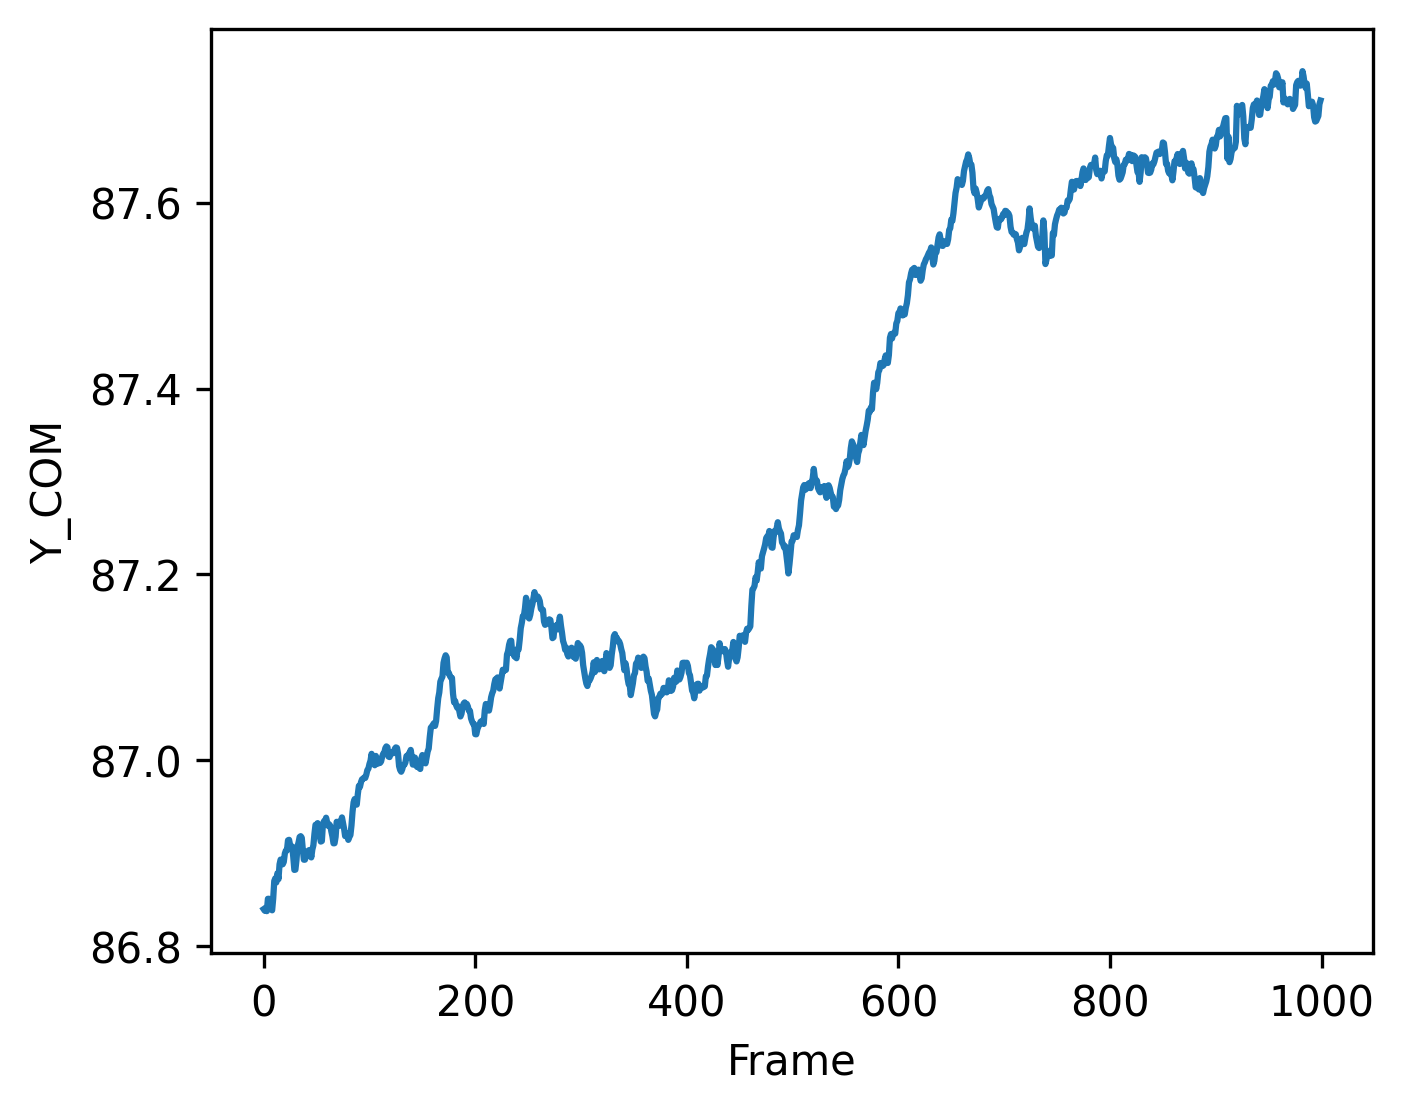

In [ ]:
plt.figure(figsize=(5,4),dpi=300)
plt.plot(Xcom)
plt.xlabel('Frame')
plt.ylabel('X_COM')
plt.savefig(fname+'Xcom.png')

plt.figure(figsize=(5,4),dpi=300)
plt.plot(Ycom)
plt.xlabel('Frame')
plt.ylabel('Y_COM')
plt.savefig(fname+'Ycom.png')
fulltime = np.arange(lastframe)
#np.savetxt(fname+' COM data.txt', np.transpose([fulltime,Xcom,Ycom]),delimiter='\t')

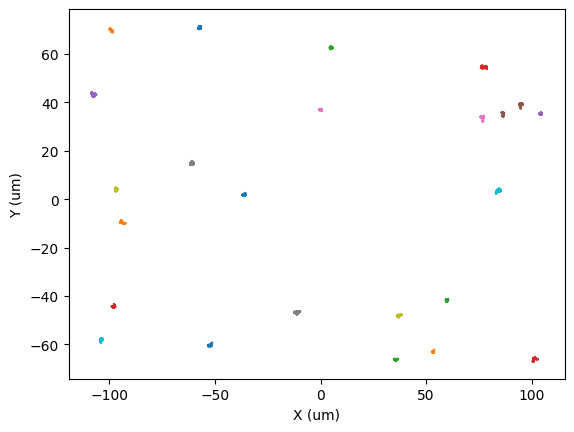

In [ ]:
msds = []
# Initialize lists to store the x and y positions for the current track.
xpos = []
ypos = []
i = []
# Initialize a list to store the number of data points used in calculating
# the MSD for each track.
msdsizes = []

# Initialize lists to store the first and last MSD values of each track.
first_values = []
last_values = []

# Iterate over each track in the 'pos' dictionary.
for l in range(int(len(pos))):
    # Initialize the starting frame for the current track based on its first
    # data point.
    start = int(pos[str(l)]['trackData'][0, 0])
    # Calculate the x and y positions, adjust for pixel scaling, and subtract
    # the center of mass position to center the data.
    xpos = pos[str(l)]['trackData'][0:minframe, 1] * pixel_conversion - Xcom[start:start + minframe]
    ypos = pos[str(l)]['trackData'][0:minframe, 2] * pixel_conversion - Ycom[start:start + minframe]

    # Plot the adjusted x and y positions for the current track.
    plt.plot(xpos, ypos)
    # Determine the number of data points in the current track.
    nData = len(xpos)
    # Calculate the maximum delta T (time lag) as half the number of data points to avoid redundancy.
    numberOfdeltaT = int(nData / 2)
    # Initialize an array to store the MSD values and their corresponding time lags.
    msd = np.zeros((numberOfdeltaT, 2))

    # Initialize a counter for indexing the MSD array.
    k = 0
    # Iterate over all possible delta T values.
    for dt in range(numberOfdeltaT + 1):
        # Skip the case where delta T is 0 as it does not provide displacement information.
        if dt == 0:
            continue
        # Calculate the displacements in x and y for the current delta T.
        deltax = xpos[1 + dt:len(xpos) - 1] - xpos[1:len(xpos) - 1 - dt]
        deltay = ypos[1 + dt:len(ypos) - 1] - ypos[1:len(ypos) - 1 - dt]

        # Calculate the square displacement for each point and delta T.
        sD = deltax ** 2 + deltay ** 2
        # Store the time lag and mean square displacement for the current delta T.
        msd[k, 0] = frametime * dt
        msd[k, 1] = np.mean(sD)
        # Increment the MSD array index.
        k = k + 1

    # Append the MSD data for the current track to the list of all tracks' MSD data.
    msds.append({"time": msd[:, 0], "MSD": msd[:, 1]})
    # Append the number of MSD data points for the current track to 'msdsizes'.
    msdsizes.append(len(msd))
    # Store the first and last MSD values of the current track.
    first_values.append(msd[0, 1])
    last_values.append(msd[-1, 1])

    # Reset the x and y positions and index list for the next track.
    xpos = []
    ypos = []
    i = []

    # Set the labels for the x and y axes of the plot.
    plt.xlabel('X (um)')
    plt.ylabel('Y (um)')
    # Save the plot of the current track's movement with the filename 'tracks.png'.
    plt.savefig(fname + 'tracks.png')


In [ ]:
(xpos[1+dt:len(xpos)-1]), (xpos[1:len(xpos)-1-dt])

([], [])

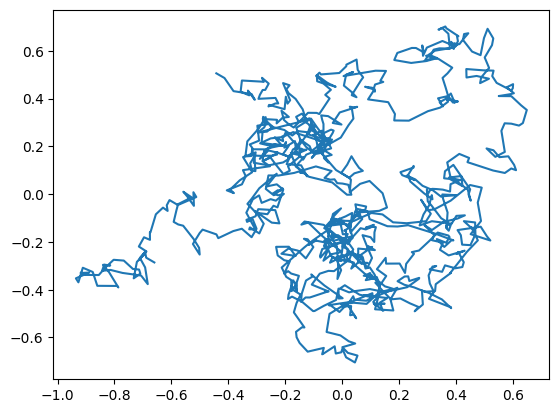

In [ ]:
# Extract the start time (first frame) of track data for the first particle/object.
start = int(pos[str(0)]['trackData'][0, 0])

# Extract the x-position data for the first particle/object from the start to
# the minimum frame number, converting the positions to physical units using a
# pixel to unit conversion factor. Then, shift this position data by subtracting
# the x-component of the center of mass position (Xcom) corresponding to the
# same time interval.
xpos = pos[str(0)]['trackData'][0:minframe, 1] * pixel_conversion - Xcom[start:start + minframe]

# Similarly, extract and convert the y-position data for the first particle/object
# and shift it by the y-component of the center of mass position (Ycom) over the same interval.
ypos = pos[str(0)]['trackData'][0:minframe, 2] * pixel_conversion - Ycom[start:start + minframe]

# Center the x-position data around its mean by subtracting the mean x-position
# from each x-position value. This operation aligns the track's average position with the origin.
xpos = xpos - np.mean(xpos)

# Likewise, center the y-position data around its mean to align the track's
# average position with the origin.
ypos = ypos - np.mean(ypos)

# Plot the centered x and y positions on a scatter plot. This visualizes the
# path of the particle/object relative to its average position, which is now the origin.
plt.plot(xpos, ypos)

# Save the centered track data to a text file named "individual track.txt".
# The data is saved in two columns, with x positions in the first column and y
# positions in the second, transposing the array to match this format.
np.savetxt("individual track.txt", np.transpose(np.array([xpos, ypos])))

# Save the plot to an image file, naming it by appending 'individual track.png'
# to the base filename 'fname'. This creates a visual record of the particle/object's path.
plt.savefig(fname + 'individual track.png')


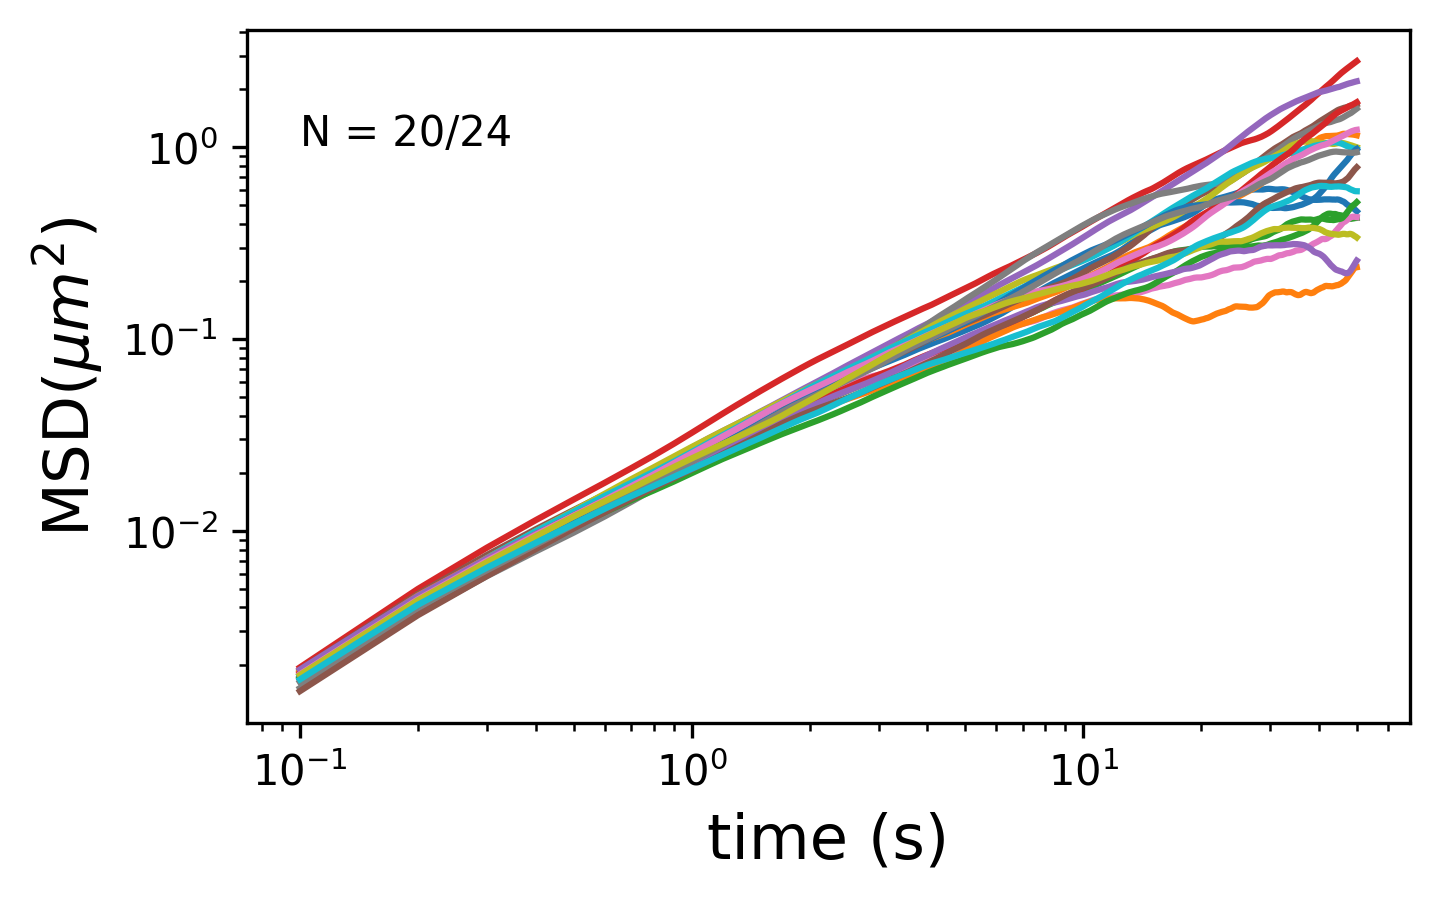

In [ ]:
# Calculate the outlier bounds for the first and last values of the MSD datasets.
lower_bound, upper_bound, lower_bound_l, upper_bound_l = get_outlier_bounds(first_values, last_values)

# Determine the smallest size of the MSD datasets to ensure consistent array
# sizes for averaging.
lastind = np.min(msdsizes) - 1

# Initialize an array to hold the total MSD values for averaging later, with a
# length equal to the smallest MSD dataset size.
totmsd = np.zeros((lastind,))

# Initialize a 2D array to hold all MSD values for each dataset, used for
# individual track analysis potentially.
msd_all = np.zeros((lastind, len(msds)))

# Setup the figure for plotting MSD curves with specified size and resolution.
plt.figure(figsize=(5, 3), dpi=300)

# Set the labels for the x and y axes with specified font sizes.
plt.xlabel('time (s)', fontsize=15)
plt.ylabel('MSD($\mu m^2$)', fontsize=15)

# Initialize a counter to keep track of the number of datasets that pass the
# filtering criteria.
count = 0

# Iterate through each MSD dataset.
for i in range(len(msds)):
    # Extract the MSD and time values from the current dataset.
    mmd = np.array(msds[i]['MSD'])
    time = msds[i]['time']

    # Apply filtering criteria based on the calculated outlier bounds and a threshold value.
    # If the dataset doesn't meet the criteria, continue to the next iteration without
    # including it in further calculations.
    if not lower_bound < np.log(mmd[0]) < upper_bound or not lower_bound_l < np.log(mmd[-1]) < upper_bound_l or mmd[lastind] < 1e-9:
        continue

    # Plot the MSD curve for the current dataset up to the last consistent index
    # across all datasets.
    plt.loglog(time[:lastind], mmd[:lastind])

    # Add the current dataset's MSD values to the total MSD for averaging.
    totmsd = totmsd + mmd[0:lastind]

    # Increment the count of datasets that passed the filtering criteria.
    count += 1

# Calculate the average MSD across all datasets that passed the filtering criteria.
msdavg = totmsd / count

# Add a text annotation to the plot indicating the number of datasets included
# out of the total.
plt.text(min(time), max(msdavg), 'N = ' + str(count) + '/' + str(len(msds)))

# Save the plot to EPS and PNG files with specified filenames and tight bounding
# boxes.
plt.savefig(fname + 'MSDs_all.eps', bbox_inches='tight')
plt.savefig(fname + 'MSDs_all.png', bbox_inches='tight')

# Trim the time array to match the size of the averaged MSD data.
time = time[0:lastind]

# Optionally (commented out), plot the average MSD as points.
# plt.loglog(time, msdavg, 'o')

# Save the time and averaged MSD data to a text file with tab delimiters.
np.savetxt(fname + 'MSD_new.txt', np.transpose([time, msdavg]), delimiter='\t')


[[Model]]
    Model(MSDfitfit)
[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 24
    # data points      = 499
    # variables        = 3
    chi-square         = 0.03953251
    reduced chi-square = 7.9703e-05
    Akaike info crit   = -4706.17574
    Bayesian info crit = -4693.53792
    R-squared          = 0.99911244
[[Variables]]
    D:      0.00670425 +/- 1.0739e-04 (1.60%) (init = 0.2)
    alpha:  0.93641131 +/- 0.00387729 (0.41%) (init = 1)
    N:      6.2958e-16 +/- 0.00172371 (273786703404529.00%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(D, alpha) = -0.9965
    C(D, N)     = -0.9093
    C(alpha, N) = +0.8771


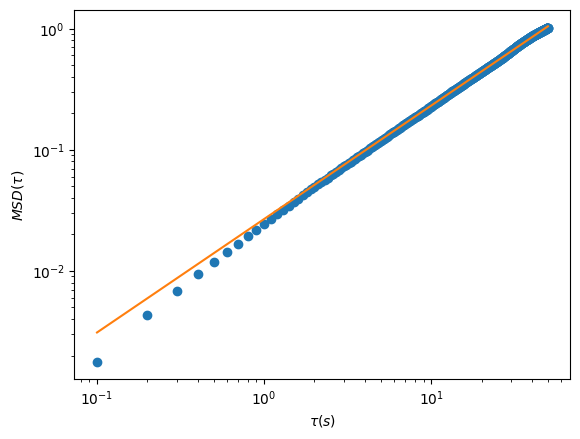

In [ ]:
def MSDfitfit(t, D,alpha,N):
    return 4*D*t**alpha + N

modely = lmfit.Model(MSDfitfit)
params = modely.make_params(D=1.,alpha=1.,N=0)


params['D'].set(value=.2, vary=True)
params['alpha'].set(value=1.0, vary=True)
params['N'].set(value=0.,max=msdavg[0],min=0., vary=True)

start=0
end=500

fitresy = modely.fit(msdavg[start:end], t=time[start:end], params=params ,method='least_squares')
print(fitresy.fit_report())

plt.loglog(time[start:end],msdavg[start:end],'o')
plt.loglog(time[start:end], fitresy.best_fit)
#plt.loglog(time[start:end], fitresy.init_fit)
plt.xlabel(r'$\tau (s)$')
plt.ylabel(r'$MSD(\tau)$')
plt.savefig(fname+'MSDfit.png',bbox_inches='tight')
timenew=np.logspace(-5,10,100000)
#Jnew=modely.eval(fitresy.params,t=timenew)
np.savetxt(fname+'MSDandfit.txt',np.transpose([time[start:end],msdavg[start:end],fitresy.best_fit]))

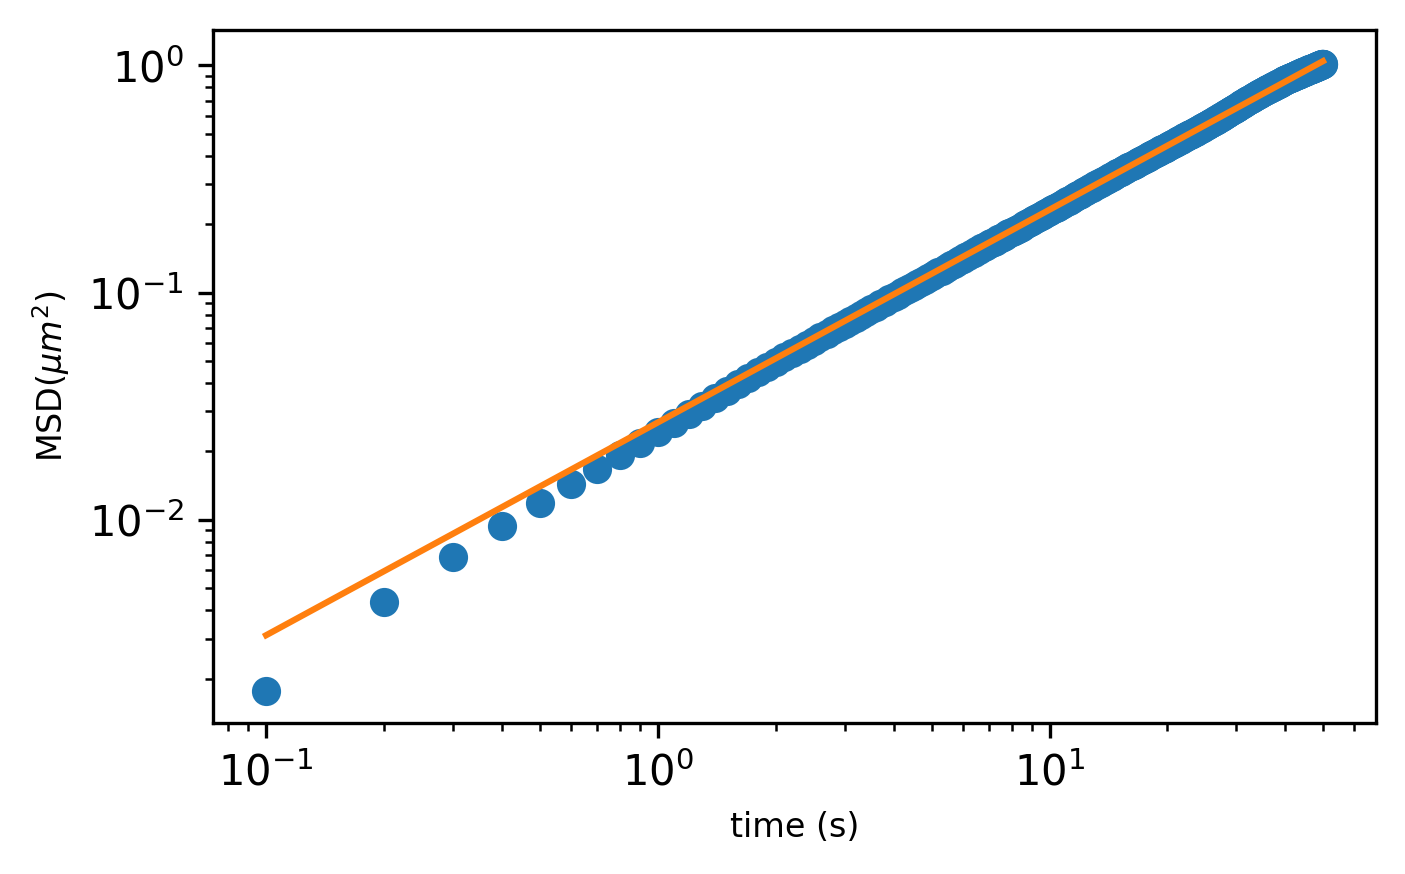

In [ ]:
plt.figure(figsize=(5,3),dpi=300)
plt.loglog(time[start:end],msdavg[start:end],'o')
plt.loglog(time[start:end], fitresy.best_fit)
plt.xlabel('time (s)',fontsize=8)
plt.ylabel('MSD($\mu m^2$)',fontsize=8)
plt.savefig(fname+'MSDs_fit.svg',bbox_inches='tight')

In [ ]:
def MSDfitfit(t, D,alpha,N):
    return 4*D*t**alpha + N

k=  1.38064852e-23 #boltzmann const
const = 1e18*k/(6*np.pi)
eta = const*(T+273.15)/(R*fitresy.best_values['D'])
eta # in Pa.s

0.10785878584588723